In [0]:
!apt-get install unzip
!rm -rf data.zip
!rm -rf data.csv
!rm -rf sample_data
!wget http://www.mariofrank.net/touchalytics/data.zip
!unzip data.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
--2018-12-07 08:25:46--  http://www.mariofrank.net/touchalytics/data.zip
Resolving www.mariofrank.net (www.mariofrank.net)... 81.169.145.94, 2a01:238:20a:202:1094::
Connecting to www.mariofrank.net (www.mariofrank.net)|81.169.145.94|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5213700 (5.0M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   4.97M   246KB/s    in 22s     

2018-12-07 08:26:09 (235 KB/s) - ‘data.zip’ saved [5213700/5213700]

Archive:  data.zip
   creating: data/
  inflating: data/data.csv           
  inflating: data/readme_data.txt    


In [0]:
# uploading manually database
# from google.colab import files

# data = files.upload()

# for fn in data.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(data[fn])))

In [0]:
import copy
import csv
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import optimizers
from keras import regularizers
from keras import layers
from keras.utils import to_categorical
from keras.constraints import maxnorm
from sklearn.model_selection import StratifiedKFold
from random import shuffle
from random import seed
from sklearn.utils import class_weight


def norm(val, mins, maxs):
    # function normalizing values of records
    ret = np.zeros(len(val))
    for i in range(len(val)):
        ret[i] = (float(val[i])-mins[i])/(maxs[i]-mins[i])
    return ret


def training_visualize(history, flag):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    if flag:
        plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    if flag:
        plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# upload dataset records
records = []
input = open('data/data.csv')
reader = csv.reader(input,delimiter=',')
for line in reader:
    records.append(line)
print(len(records));

temp_arr = np.array(records).astype(np.float)
# get min max needed for normalization
maxes = np.max(temp_arr,axis=0)
mines = np.min(temp_arr,axis=0)

# create array of strokes from records
strokes_pre = [];
temp = [];
for record in records:
    if record[4] == '0':
        if len(temp) != 0:
            strokes_pre.append(copy.deepcopy(temp));
        temp.clear();
        temp.append(record);
    else:
        temp.append(record);

strokes_pre.append(copy.deepcopy(temp));

print(len(strokes_pre));

# apply threshold to drop not long enough strokes
strokes = []
threshold = 5
for i in range(len(strokes_pre)):
    str = strokes_pre[i];
    if len(str) >= threshold:
        strokes.append(str);
print(len(strokes));

# shuffle strokes array
seed(543)
shuffle(strokes)

# get strokes array per user
strokes_per_user = []
for i in range(41):
    temp = []
    strokes_per_user.append(temp);
for val in strokes:
    index = int(val[0][1])
    strokes_per_user[index].append(copy.deepcopy(val));

seed(544)
for i in range(41):
    shuffle(strokes_per_user[i])

# get 80% of each class for training strokes, rest 20% for testing
training_strokes = []
testing_strokes = []
for i in range(41):
    for j in range(len(strokes_per_user[i])):
        if j > int(0.8*len(strokes_per_user[i])):
            testing_strokes.append(strokes_per_user[i][j]);
        else:
            training_strokes.append(strokes_per_user[i][j])

print("training strokes length:")
print(len(training_strokes))
print("training strokes length:")
print(len(testing_strokes))

# paremeters of stroke: window = how many records each stroke has, properties = how many parematers from records to take
window = threshold
properties_size = 7

train_data = []
train_labels = []

seed(555)
shuffle(training_strokes)
# seed(556)
# shuffle(testing_strokes)

912133
21174
20377
training strokes length:
16328
training strokes length:
4049


In [0]:
# create training data and labels from training strokes as a fix window sliding
for stroke in training_strokes:
    str_len = len(stroke)
    if str_len < window:
        temp = stroke;
        for j in range(len(temp)):
            temp[j] = norm(temp[j],mines,maxes);
            temp[j] = temp[j][4:];

        for i in range(window-str_len):
            temp.append([0] * properties_size)
        train_data.append(temp)
        print("it should not be here")
        train_labels.append(int(stroke[0][1]))
    else:
        for i in range(str_len-window+1):
            temp = stroke[i:(i+window)];
            for j in range(len(temp)):
                temp[j] = norm(temp[j],mines,maxes);
                temp[j] = temp[j][4:];
            train_data.append(temp)
            train_labels.append(int(stroke[0][1]))

print("train data length")
print(len(train_data))

# class weight compute
class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
print("classes weights related to inverse class frequency ")
print(class_weights)

train data length
663773
classes weights related to inverse class frequency 
[1.13499617 0.53244706 0.65832732 2.66057278 1.69471217 1.02673677
 2.15344312 0.6684939  2.47433675 0.51616724 1.98889255 1.03315797
 1.08233623 0.70969601 1.2568578  1.37736816 0.78969735 1.49391763
 1.07486292 2.20506475 0.41931068 2.01739382 2.3311138  3.47714462
 1.3943317  1.66610943 0.6130561  0.58212885 1.00989242 2.48002227
 1.32788594 3.46894908 1.32603697 1.79028921 0.18462925 1.24191358
 1.83077975 1.04408522 1.50363011 0.8823624  3.32845094]


Train on 531018 samples, validate on 132755 samples
Epoch 1/200
 - 16s - loss: 1.6596 - acc: 0.5456 - val_loss: 1.5810 - val_acc: 0.5589
Epoch 2/200
 - 14s - loss: 1.2905 - acc: 0.6180 - val_loss: 1.2898 - val_acc: 0.6261
Epoch 3/200
 - 14s - loss: 1.1458 - acc: 0.6449 - val_loss: 1.2142 - val_acc: 0.6292
Epoch 4/200
 - 14s - loss: 1.0560 - acc: 0.6632 - val_loss: 1.1571 - val_acc: 0.6454
Epoch 5/200
 - 14s - loss: 0.9905 - acc: 0.6777 - val_loss: 1.1330 - val_acc: 0.6535
Epoch 6/200
 - 14s - loss: 0.9431 - acc: 0.6879 - val_loss: 1.1142 - val_acc: 0.6592
Epoch 7/200
 - 14s - loss: 0.9036 - acc: 0.6983 - val_loss: 1.1182 - val_acc: 0.6592
Epoch 8/200
 - 14s - loss: 0.8707 - acc: 0.7055 - val_loss: 1.1025 - val_acc: 0.6639
Epoch 9/200
 - 14s - loss: 0.8406 - acc: 0.7135 - val_loss: 1.1057 - val_acc: 0.6569
Epoch 10/200
 - 14s - loss: 0.8164 - acc: 0.7196 - val_loss: 1.0785 - val_acc: 0.6679
Epoch 11/200
 - 14s - loss: 0.7962 - acc: 0.7256 - val_loss: 1.0926 - val_acc: 0.6629
Epoch 12/20

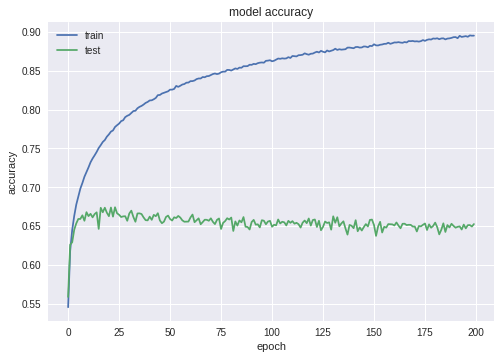

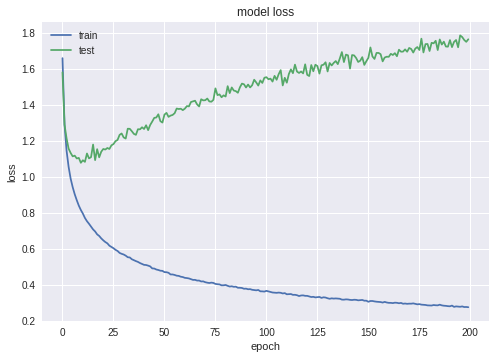

In [0]:
from keras.layers.normalization import BatchNormalization

batches = 2048
droppout = 0.5
epochs = 200
max_nor = 4

model = models.Sequential()
# hidden layers

model.add(BatchNormalization())
model.add(layers.Dense(1024, input_shape=(window * properties_size,)))
model.add(BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))


model.add(layers.Dense(2048))
model.add(BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Dense(1024))
model.add(BatchNormalization())
model.add(layers.Activation('relu'))
# model.add(layers.Dense(64, activation='relu', kernel_constraint=maxnorm(max_nor), kernel_initializer='normal'))
# model.add(layers.Dropout(droppout))

# output layer
model.add(BatchNormalization())
model.add(layers.Dense(41))
model.add(BatchNormalization())
model.add(layers.Activation('softmax'))


# adam = optimizers.adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

reshaped_train_data = np.array(train_data).reshape((len(train_data),window*properties_size))
np_array_l1 = np.array(to_categorical(train_labels,41))

history = model.fit(reshaped_train_data, np_array_l1,class_weight=class_weights, epochs=epochs,validation_split=0.2,
                    shuffle=True, batch_size=batches, verbose=2)

model.save('model.h5')
print("model saved to file")
print("training accuracy is: %s" % (history.history['acc'][epochs-1]*100))
training_visualize(history,True)


In [0]:
from keras.models import load_model
model = load_model('model.h5')

In [0]:
import numpy as np

test_data = []
test_labels = []
# create testing data and labels from testing strokes as a fix window sliding
for stroke in testing_strokes:
    str_len = len(stroke)
    if str_len < window:
        temp = stroke;
        for j in range(len(temp)):
            temp[j] = norm(temp[j],mines,maxes);
            temp[j] = temp[j][4:];

        for i in range(window-str_len):
            temp.append([0] * properties_size)
        test_data.append(temp)
        test_labels.append(int(stroke[0][1]))
        print("it should not be here")
    else:
        for i in range(str_len-window+1):
            temp = stroke[i:(i+window)];
            for j in range(len(temp)):
                temp[j] = norm(temp[j],mines,maxes);
                temp[j] = temp[j][4:];
            test_data.append(temp)
            test_labels.append(int(stroke[0][1]))

print("test data length")
print(len(test_data))

test data length
164298


In [0]:
# test labels one hot encoding
reshaped_test_data = np.array(test_data).reshape((len(test_data),window*properties_size))
test_labels = np.array(to_categorical(test_labels,41))

test_scores = model.evaluate(reshaped_test_data, test_labels, verbose=2)

print("Testing accuracy is: %.2f%%" % (test_scores[1]*100))
print("Testing loss is: %.2f" % (test_scores[0]))

Testing accuracy is: 67.00%
Testing loss is: 2.11


In [0]:
# calculating EER
# 1 creating structure of [ softmax output | ID ]
softmax_id = []

new_struct = []
value = 8;
print(len(testing_strokes))
for i in range(len(testing_strokes)):
    to_rem = i
    temp = []
    temp.append(copy.deepcopy(testing_strokes[i]))
    i+=1
    while len(temp) != value and i<len(testing_strokes):
        while testing_strokes[i][0][1] != temp[0][0][1] and i<len(testing_strokes)-1:
            i+=1
        temp.append(copy.deepcopy(testing_strokes[i]))
        i+=1;
    new_struct.append(copy.deepcopy(temp))    
    i = to_rem
print(len(new_struct))
print(np.shape(new_struct))
# using whole strokes to identification
success = 0;
counter = 0;
for arr in new_struct:
    # here making the windows for strokes
    temp_data = []
    temp_labels = []
    for stroke in arr:
        str_len = len(stroke)
        if str_len < window:
            temp = stroke;
            for j in range(len(temp)):
                temp[j] = norm(temp[j], mines, maxes);
                temp[j] = temp[j][4:];

            for i in range(window - str_len):
                temp.append([0] * properties_size)
            temp_data.append(temp)
            temp_labels.append(int(stroke[0][1]))
        else:
            for i in range(str_len - window + 1):
                temp = stroke[i:(i + window)];
                for j in range(len(temp)):
                    temp[j] = norm(temp[j], mines, maxes);
                    temp[j] = temp[j][4:];
                temp_data.append(temp)
                temp_labels.append(int(stroke[0][1]))

    if len(temp_data[0][0]) == properties_size:
        y = np.zeros(41)
        for i in range(len(temp_data)):
            y_new = model.predict(np.array(temp_data[i]).reshape(1, (window * properties_size)))
            y=y+y_new
        y=y/len(temp_data)
        
        if np.argmax(y) == temp_labels[0]:
            success +=1
        
        softmax_id_row = []
        softmax_id_row.append(y)
        softmax_id_row.append(temp_labels[0])
        softmax_id.append(softmax_id_row)
        counter+=1
    if counter % 200 == 0:
        print(counter)

print(len(softmax_id))
print(softmax_id[0])
print(softmax_id[1])

acc = int(success/counter * 10000)/100
print("testing accuracy after getting whole strokes into testing is %s" % acc)
print("how many tests? %s" % counter)

4049
4049
(4049,)
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4049
[array([[6.00312438e-01, 1.09935351e-04, 1.02081737e-03, 3.45150997e-03,
        1.05615352e-05, 1.37423061e-04, 1.69867913e-01, 2.00401393e-05,
        1.37597222e-05, 1.25071208e-05, 3.50820473e-05, 1.08617860e-04,
        4.71743002e-05, 5.36698942e-05, 2.06777934e-05, 6.35600975e-05,
        2.48096626e-05, 5.21189058e-05, 6.72609131e-05, 3.00463807e-05,
        1.76788705e-05, 3.20659521e-02, 1.90007455e-05, 1.48063116e-05,
        9.09816254e-04, 1.71780518e-02, 3.19332941e-03, 8.65948970e-02,
        1.26261085e-05, 2.90634508e-02, 3.36206874e-06, 6.40768097e-06,
        9.51437466e-06, 5.18251382e-03, 1.40379483e-04, 2.51791717e-05,
        8.01720994e-05, 6.77253765e-03, 4.31200248e-02, 7.44478026e-05,
        5.59286406e-05]]), 0]
[array([[6.13153318e-01, 1.08971379e-04, 1.00905623e-03, 3.38385767e-03,
        1.04403880e-05, 1.35804181e-04, 1.62230577e-01, 1

clients scores
max: 0.9993645190785769
min: 3.5767947326158455e-05
impostors scores
max: 0.600574776144117
min: 9.700176951168207e-09
clients count: 4049
impostors count: 161960


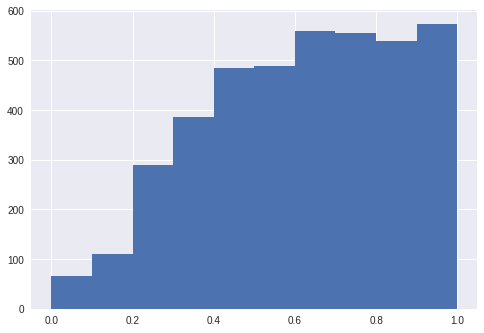

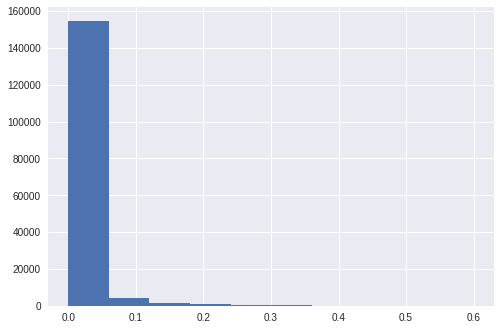

[0.0, 0.0012348728081007657, 0.002222771054581378, 0.00395159298592245, 0.006421338602123981, 0.0079031859718449, 0.009385033341565818, 0.010372931588046431, 0.012595702642627809, 0.014324524573968881, 0.016053346505309953, 0.018523092121511483, 0.0200049394912324, 0.02222771054581378, 0.0237095579155347, 0.026179303531736232, 0.02766115090145715, 0.032106693010619906, 0.036799209681402816, 0.04025685354408496, 0.0432205482835268, 0.04865398863917016, 0.0553223018029143, 0.061496665843418126, 0.06767102988392196, 0.07557421585576686, 0.08471227463571253, 0.0916275623610768, 0.09780192640158064, 0.10521116325018523, 0.1148431711533712, 0.12373425537169672, 0.130649543097061, 0.13830575450728574, 0.14818473697209186, 0.1585576685601383, 0.16794270190170413, 0.17979748085947148, 0.19041738700913804, 0.2012842677204248, 0.21042232650037046, 0.22375895282785874, 0.233884909854285, 0.24722153618177328, 0.25784144233143985, 0.27216596690540873, 0.28476166954803656, 0.2968634230674241, 0.30624

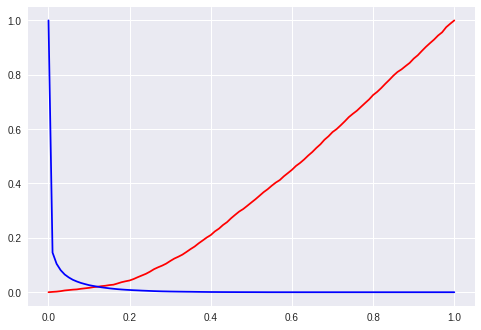

In [0]:
# EER
clients = np.zeros(len(softmax_id))
for i in range(len(softmax_id)):
  ctr = 0
  index = softmax_id[i][1]
  clients[i] = softmax_id[i][0][0][index]

print("clients scores")
# print(clients)
print("max: %s"%np.max(clients))
print("min: %s"%np.min(clients))

impostors = []
for i in range(len(softmax_id)):
  for j in range(41):
      if softmax_id[i][1] != j:
          impostors.append(softmax_id[i][0][0][j])

print("impostors scores")
# print(impostors)
print("max: %s"%np.max(impostors))
print("min: %s"%np.min(impostors))

print("clients count: %s"%len(clients))
print("impostors count: %s"%len(impostors))

# histograms of scores
plt.hist(clients)
plt.show()

plt.hist(impostors)
plt.show()

# now the EER
step = 0.01
lam = np.arange(0, 1+step, step)
far = []
frr = []
for lambd in lam:
  FAR = 0
  FRR = 0
  for i in range(len(clients)):
    if clients[i] < lambd:
        FRR+=1
  for i in range(len(impostors)):
    if impostors[i] > lambd:
        FAR+=1
  FAR/=len(impostors)
  FRR/=len(clients)
  frr.append(FRR)
  far.append(FAR)
print(frr)
print(far)

plt.plot(lam, frr, 'r', lam, far, 'b')

for i in range(len(far)):
    m = frr[i]-far[i]
    if m > 0:
        print(i)
        print("far: %s " % far[i])
        print("frr: %s " % frr[i])
        print("EER calculated not exactly: %s " % ((far[i]*100+frr[i]*100)/2))
        break

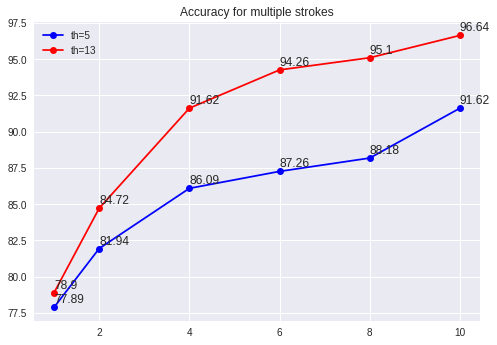

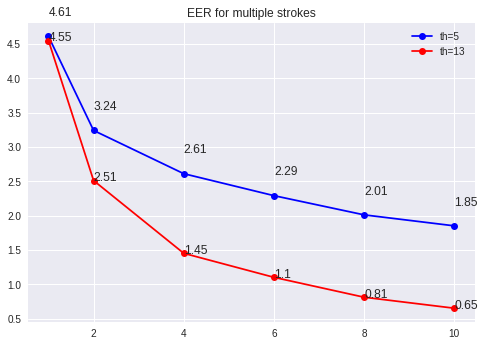

In [0]:
# Visualization of all results
x = [1,2,4,6,8,10]
acc = [ 77.89 ,81.94 , 86.09, 87.26, 88.18, 91.62]
plt.plot(x,acc,'bo-', label='th=5')
for a,b in zip(x, acc):
    plt.text(a, b+0.3,b)

acc = [ 78.9, 84.72, 91.62, 94.26, 95.1, 96.64]
plt.plot(x,acc,'ro-', label='th=13')
for a,b in zip(x, acc):
    plt.text(a, b+0.3,b)
plt.title("Accuracy for multiple strokes")
plt.legend()
plt.show()

x=[1,2,4,6,8,10]
eer = [ 4.61,3.24,2.61,2.29, 2.01, 1.85]
plt.plot(x,eer,'bo-', label='th=5')
for a,b in zip(x, eer):
    plt.text(a, b+0.3,b)

eer = [ 4.55, 2.51, 1.45, 1.1, 0.81, 0.65]
plt.plot(x,eer,'ro-', label='th=13')
for a,b in zip(x, eer):
    plt.text(a, b,b)
plt.title("EER for multiple strokes")
plt.legend()
plt.show()